In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

In [2]:
train = pd.read_csv(r'../input/playground-series-s3e12/train.csv')
test_1 = pd.read_csv(r'../input/playground-series-s3e12/test.csv')
orig_train = pd.read_csv(r'../input/kidney-stone-prediction-based-on-urine-analysis/kindey stone urine analysis.csv')

train.drop('id', axis = 1, inplace = True)
test = test_1.drop('id', axis = 1)

In [3]:
train.head()

,gravity,ph,osmo,cond,urea,calc,target
0,1.013,6.19,443,14.8,124,1.45,0
1,1.025,5.40,703,23.6,394,4.18,0
2,1.009,6.13,371,24.5,159,9.04,0
3,1.021,4.91,442,20.8,398,6.63,1
4,1.021,5.53,874,17.8,385,2.21,1


In [4]:
test.head()

,gravity,ph,osmo,cond,urea,calc
0,1.017,5.24,345,11.5,152,1.16
1,1.020,5.68,874,29.0,385,3.46
2,1.024,5.36,698,19.5,354,13.00
3,1.020,5.33,668,25.3,252,3.46
4,1.011,5.87,567,29.0,457,2.36


In [5]:
orig_train.head()

,gravity,ph,osmo,cond,urea,calc,target
0,1.021,4.91,725,14.0,443,2.45,0
1,1.017,5.74,577,20.0,296,4.49,0
2,1.008,7.20,321,14.9,101,2.36,0
3,1.011,5.51,408,12.6,224,2.15,0
4,1.005,6.52,187,7.5,91,1.16,0


In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
gravity,414.0,1.017894,0.006675,1.005,1.012,1.018,1.022,1.04
ph,414.0,5.955459,0.642260,4.760,5.530,5.740,6.280,7.94
osmo,414.0,651.545894,234.676567,187.000,455.250,679.500,840.000,1236.00
cond,414.0,21.437923,7.514750,5.100,15.500,22.200,27.600,38.00
urea,414.0,278.657005,136.442249,10.000,170.000,277.000,385.000,620.00
calc,414.0,4.114638,3.217641,0.170,1.450,3.130,6.630,14.34
target,414.0,0.444444,0.497505,0.000,0.000,0.000,1.000,1.00


In [7]:
print(f'There are {train.isna().sum().sum()} null values in train dataset')
print(f'There are {test.isna().sum().sum()} null values in test dataset')
print(f'There are {orig_train.isna().sum().sum()} null values in original train dataset\n')

print(f'There are {train.duplicated(subset = list(train)[0:-1]).value_counts()[0]} non-duplicate values out of {train.count()[0]} rows in train dataset')
print(f'There are {test.duplicated().value_counts()[0]} non-duplicate values out of {test.count()[0]} rows in test dataset')
print(f'There are {orig_train.duplicated(subset = list(train)[0:-1]).value_counts()[0]} non-duplicate values out of {orig_train.count()[0]} rows in original train dataset')

There are 0 null values in train dataset
There are 0 null values in test dataset
There are 0 null values in original train dataset

There are 414 non-duplicate values out of 414 rows in train dataset
There are 276 non-duplicate values out of 276 rows in test dataset
There are 79 non-duplicate values out of 79 rows in original train dataset


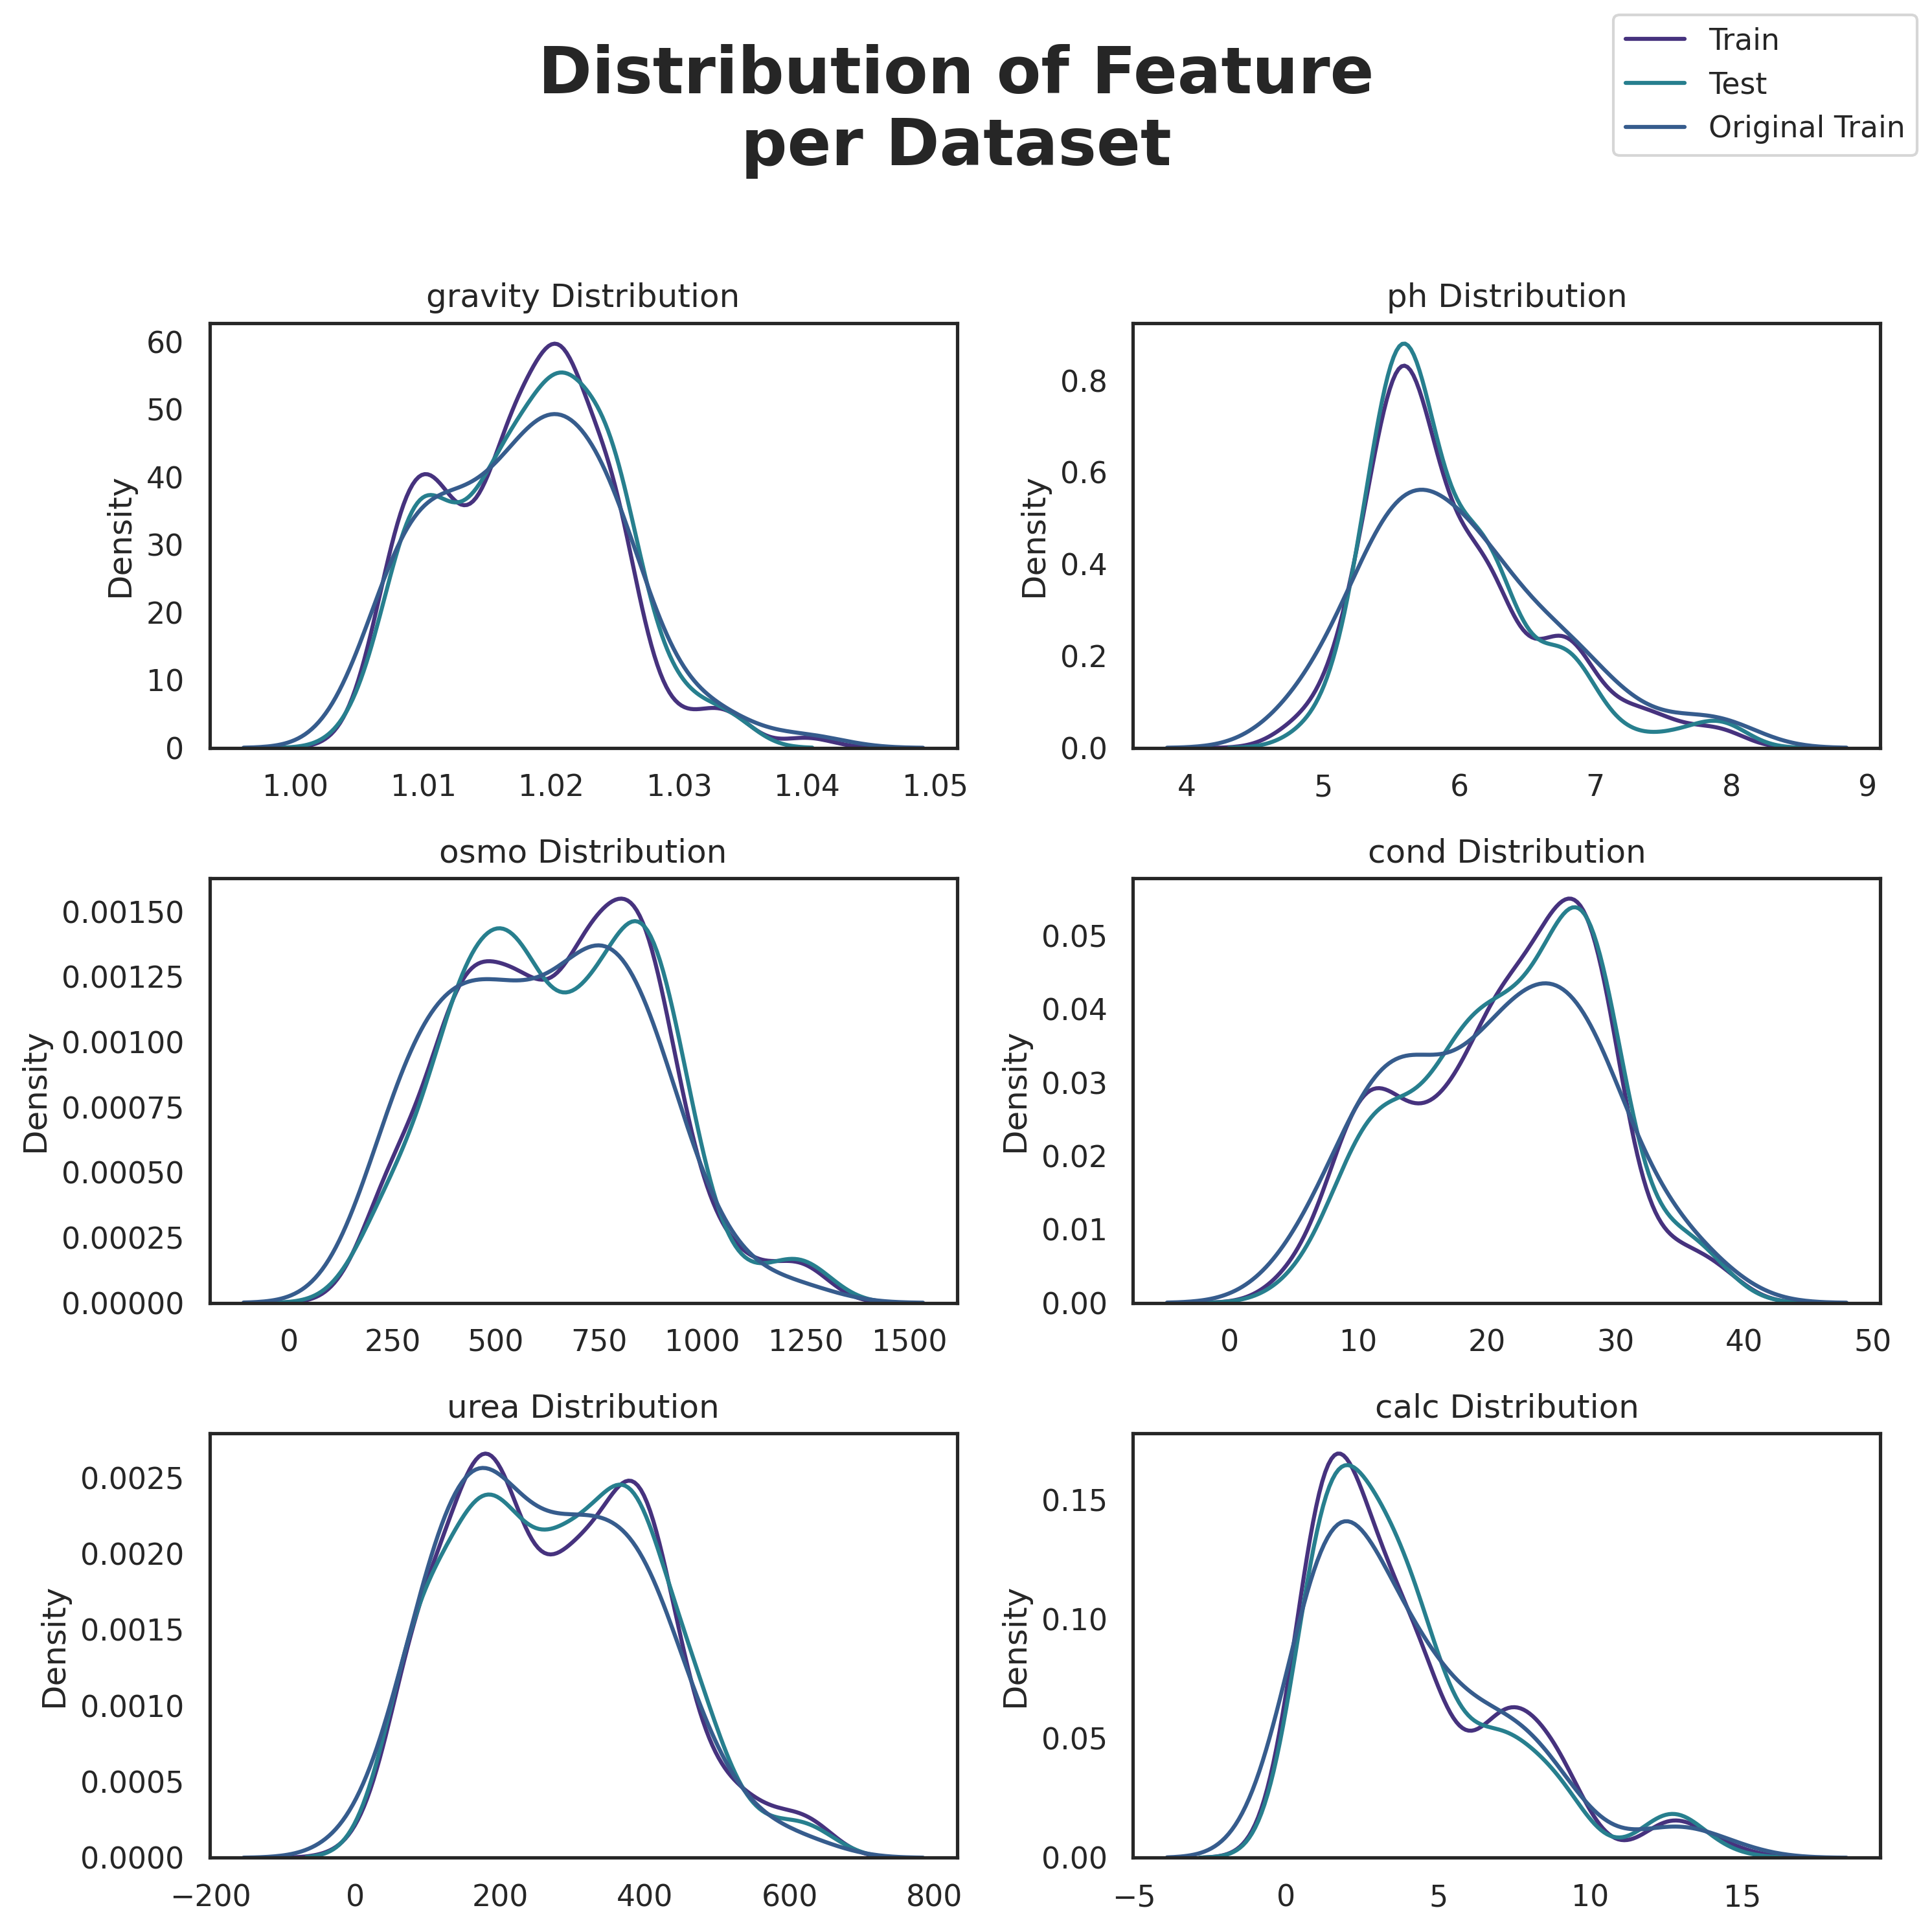

In [8]:
fig, ax = plt.subplots(3, 2, figsize = (10, 10), dpi = 300)
ax = ax.flatten()

for i, column in enumerate(test.columns):
    sns.kdeplot(train[column], ax=ax[i], color=pal[0])    
    sns.kdeplot(test[column], ax=ax[i], color=pal[2])
    sns.kdeplot(orig_train[column], ax=ax[i], color=pal[1])
    
    ax[i].set_title(f'{column} Distribution')
    ax[i].set_xlabel(None)
    
fig.suptitle('Distribution of Feature\nper Dataset\n', fontsize = 24, fontweight = 'bold')
fig.legend(['Train', 'Test', 'Original Train'])
plt.tight_layout()

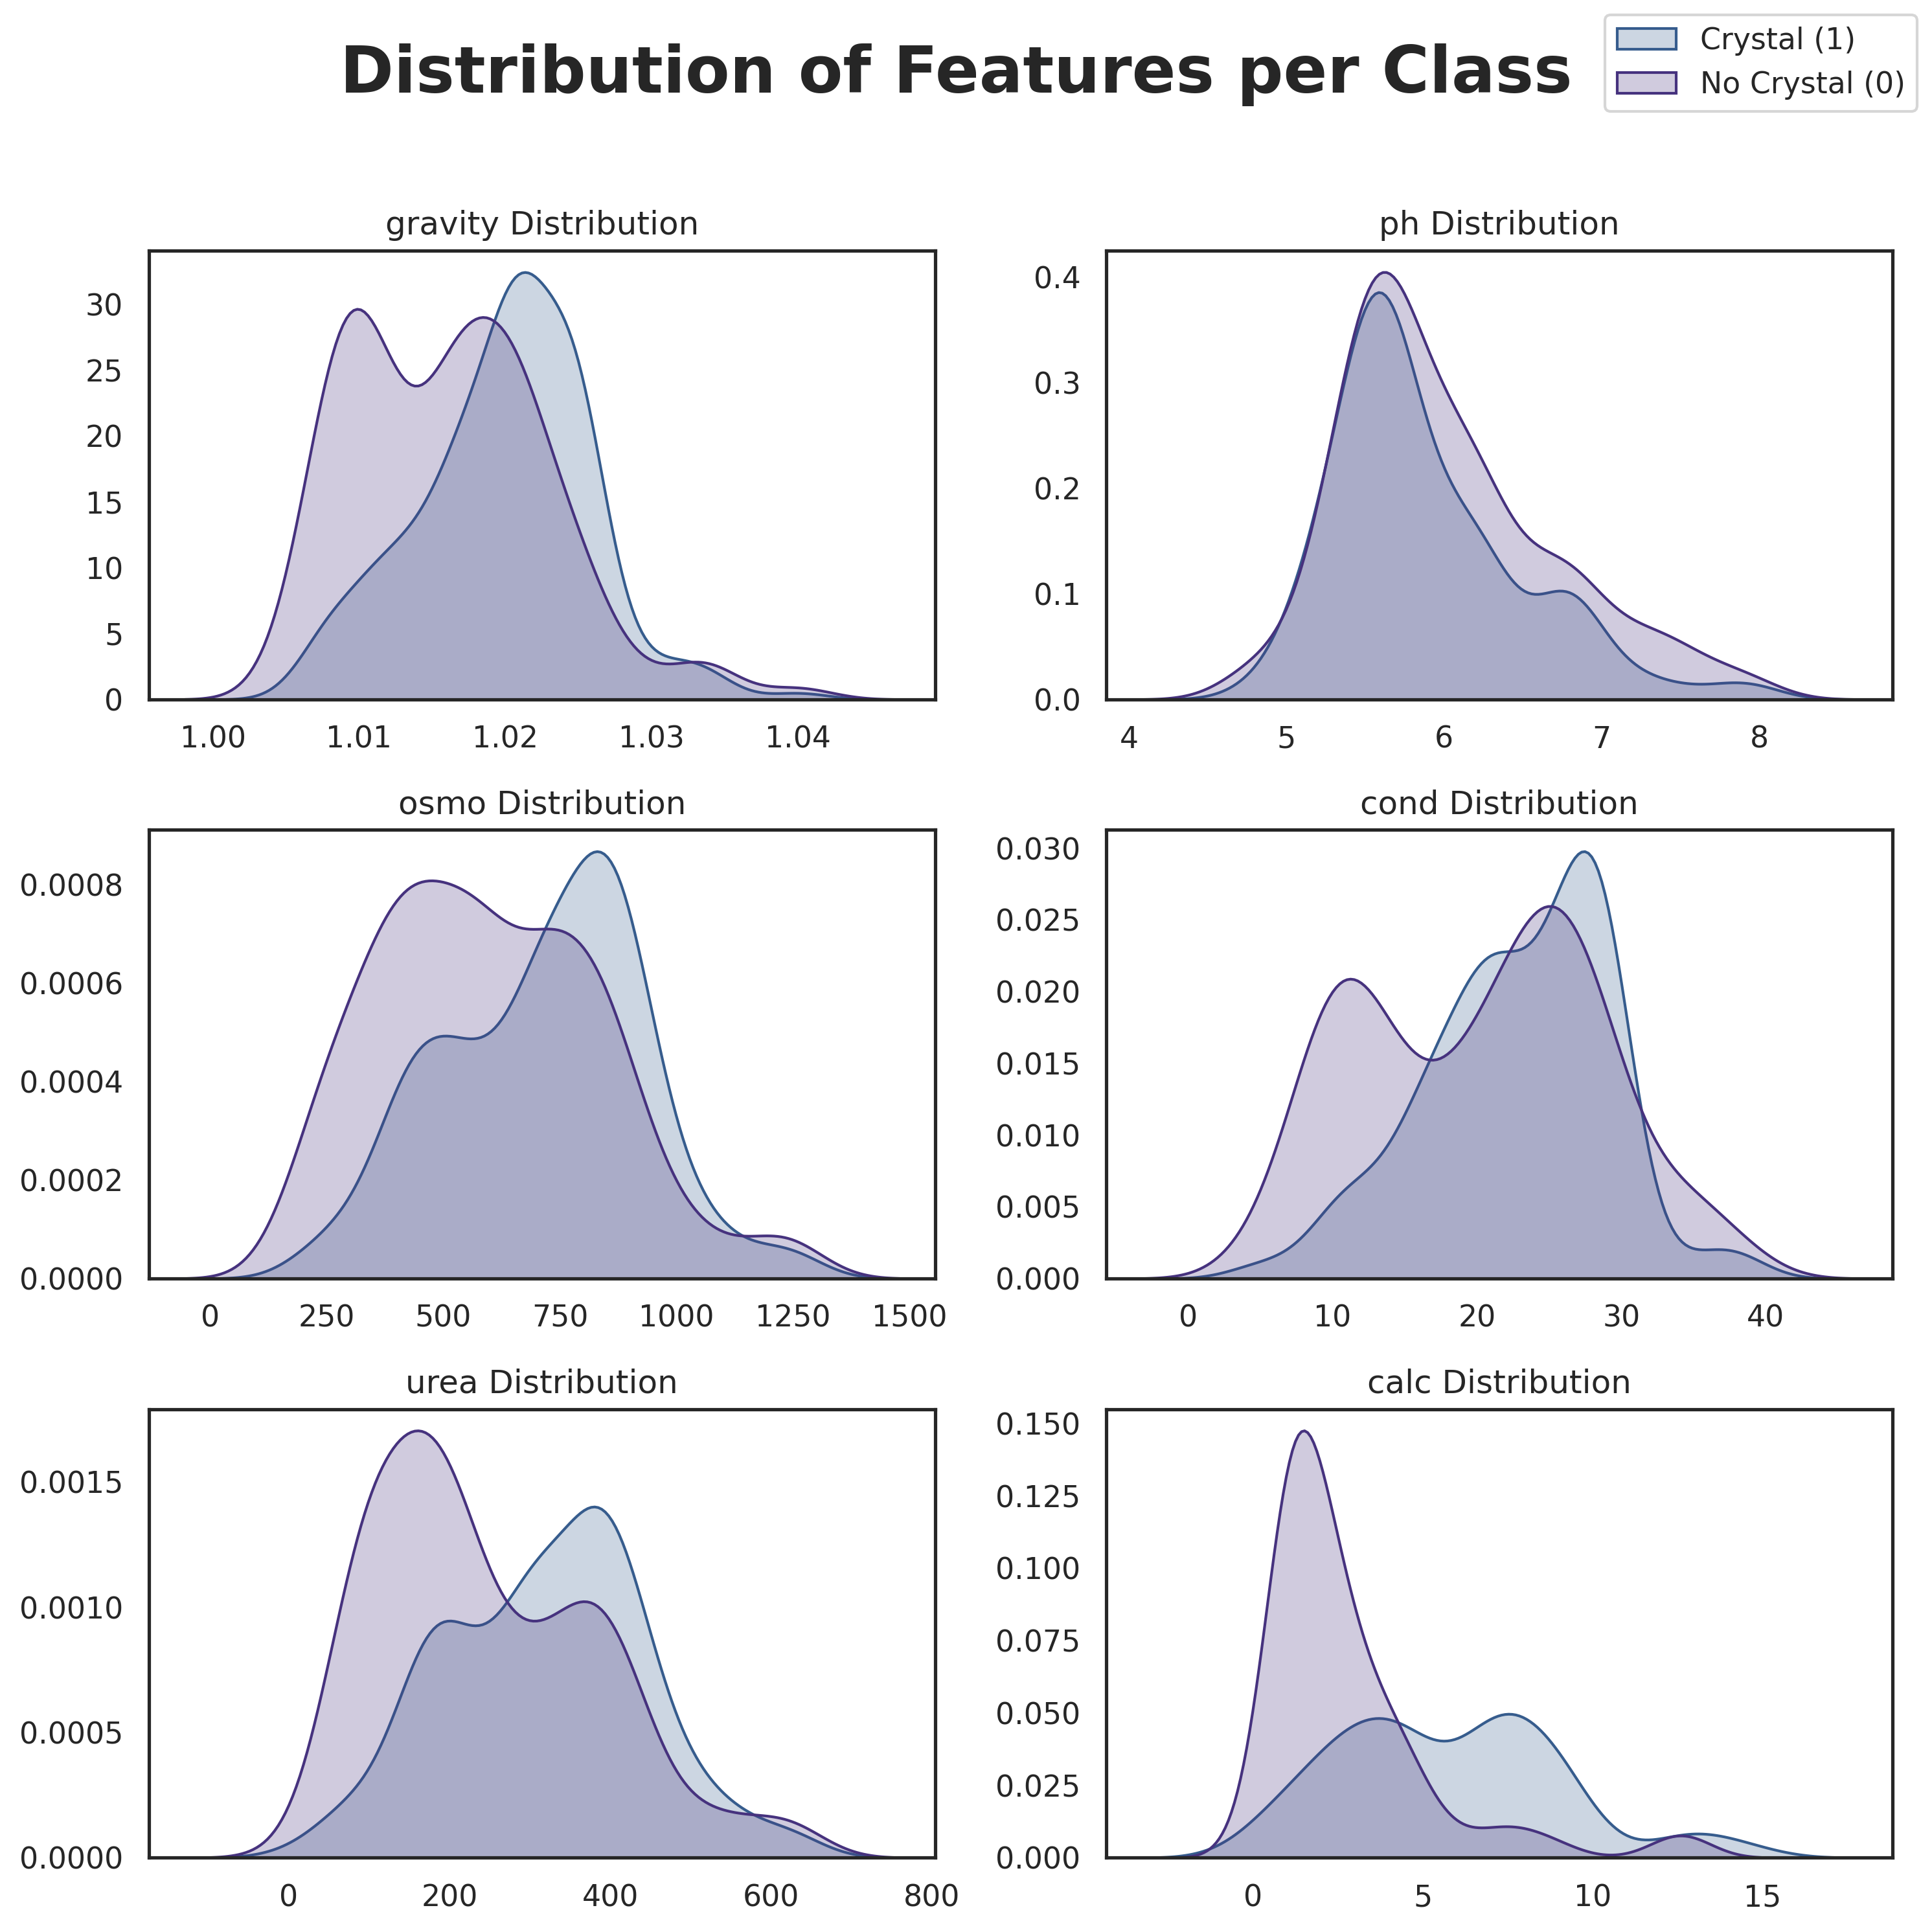

In [9]:
fig, ax = plt.subplots(3, 2, figsize = (10, 10), dpi = 300)
ax = ax.flatten()

for i, column in enumerate(test.columns):
    sns.kdeplot(data = train, x = column, ax=ax[i], color=pal[0], fill = True, legend = False, hue = 'target')
    
    ax[i].set_title(f'{column} Distribution')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(None)
    
fig.suptitle('Distribution of Features per Class\n', fontsize = 24, fontweight = 'bold')
fig.legend(['Crystal (1)', 'No Crystal (0)'])
plt.tight_layout()

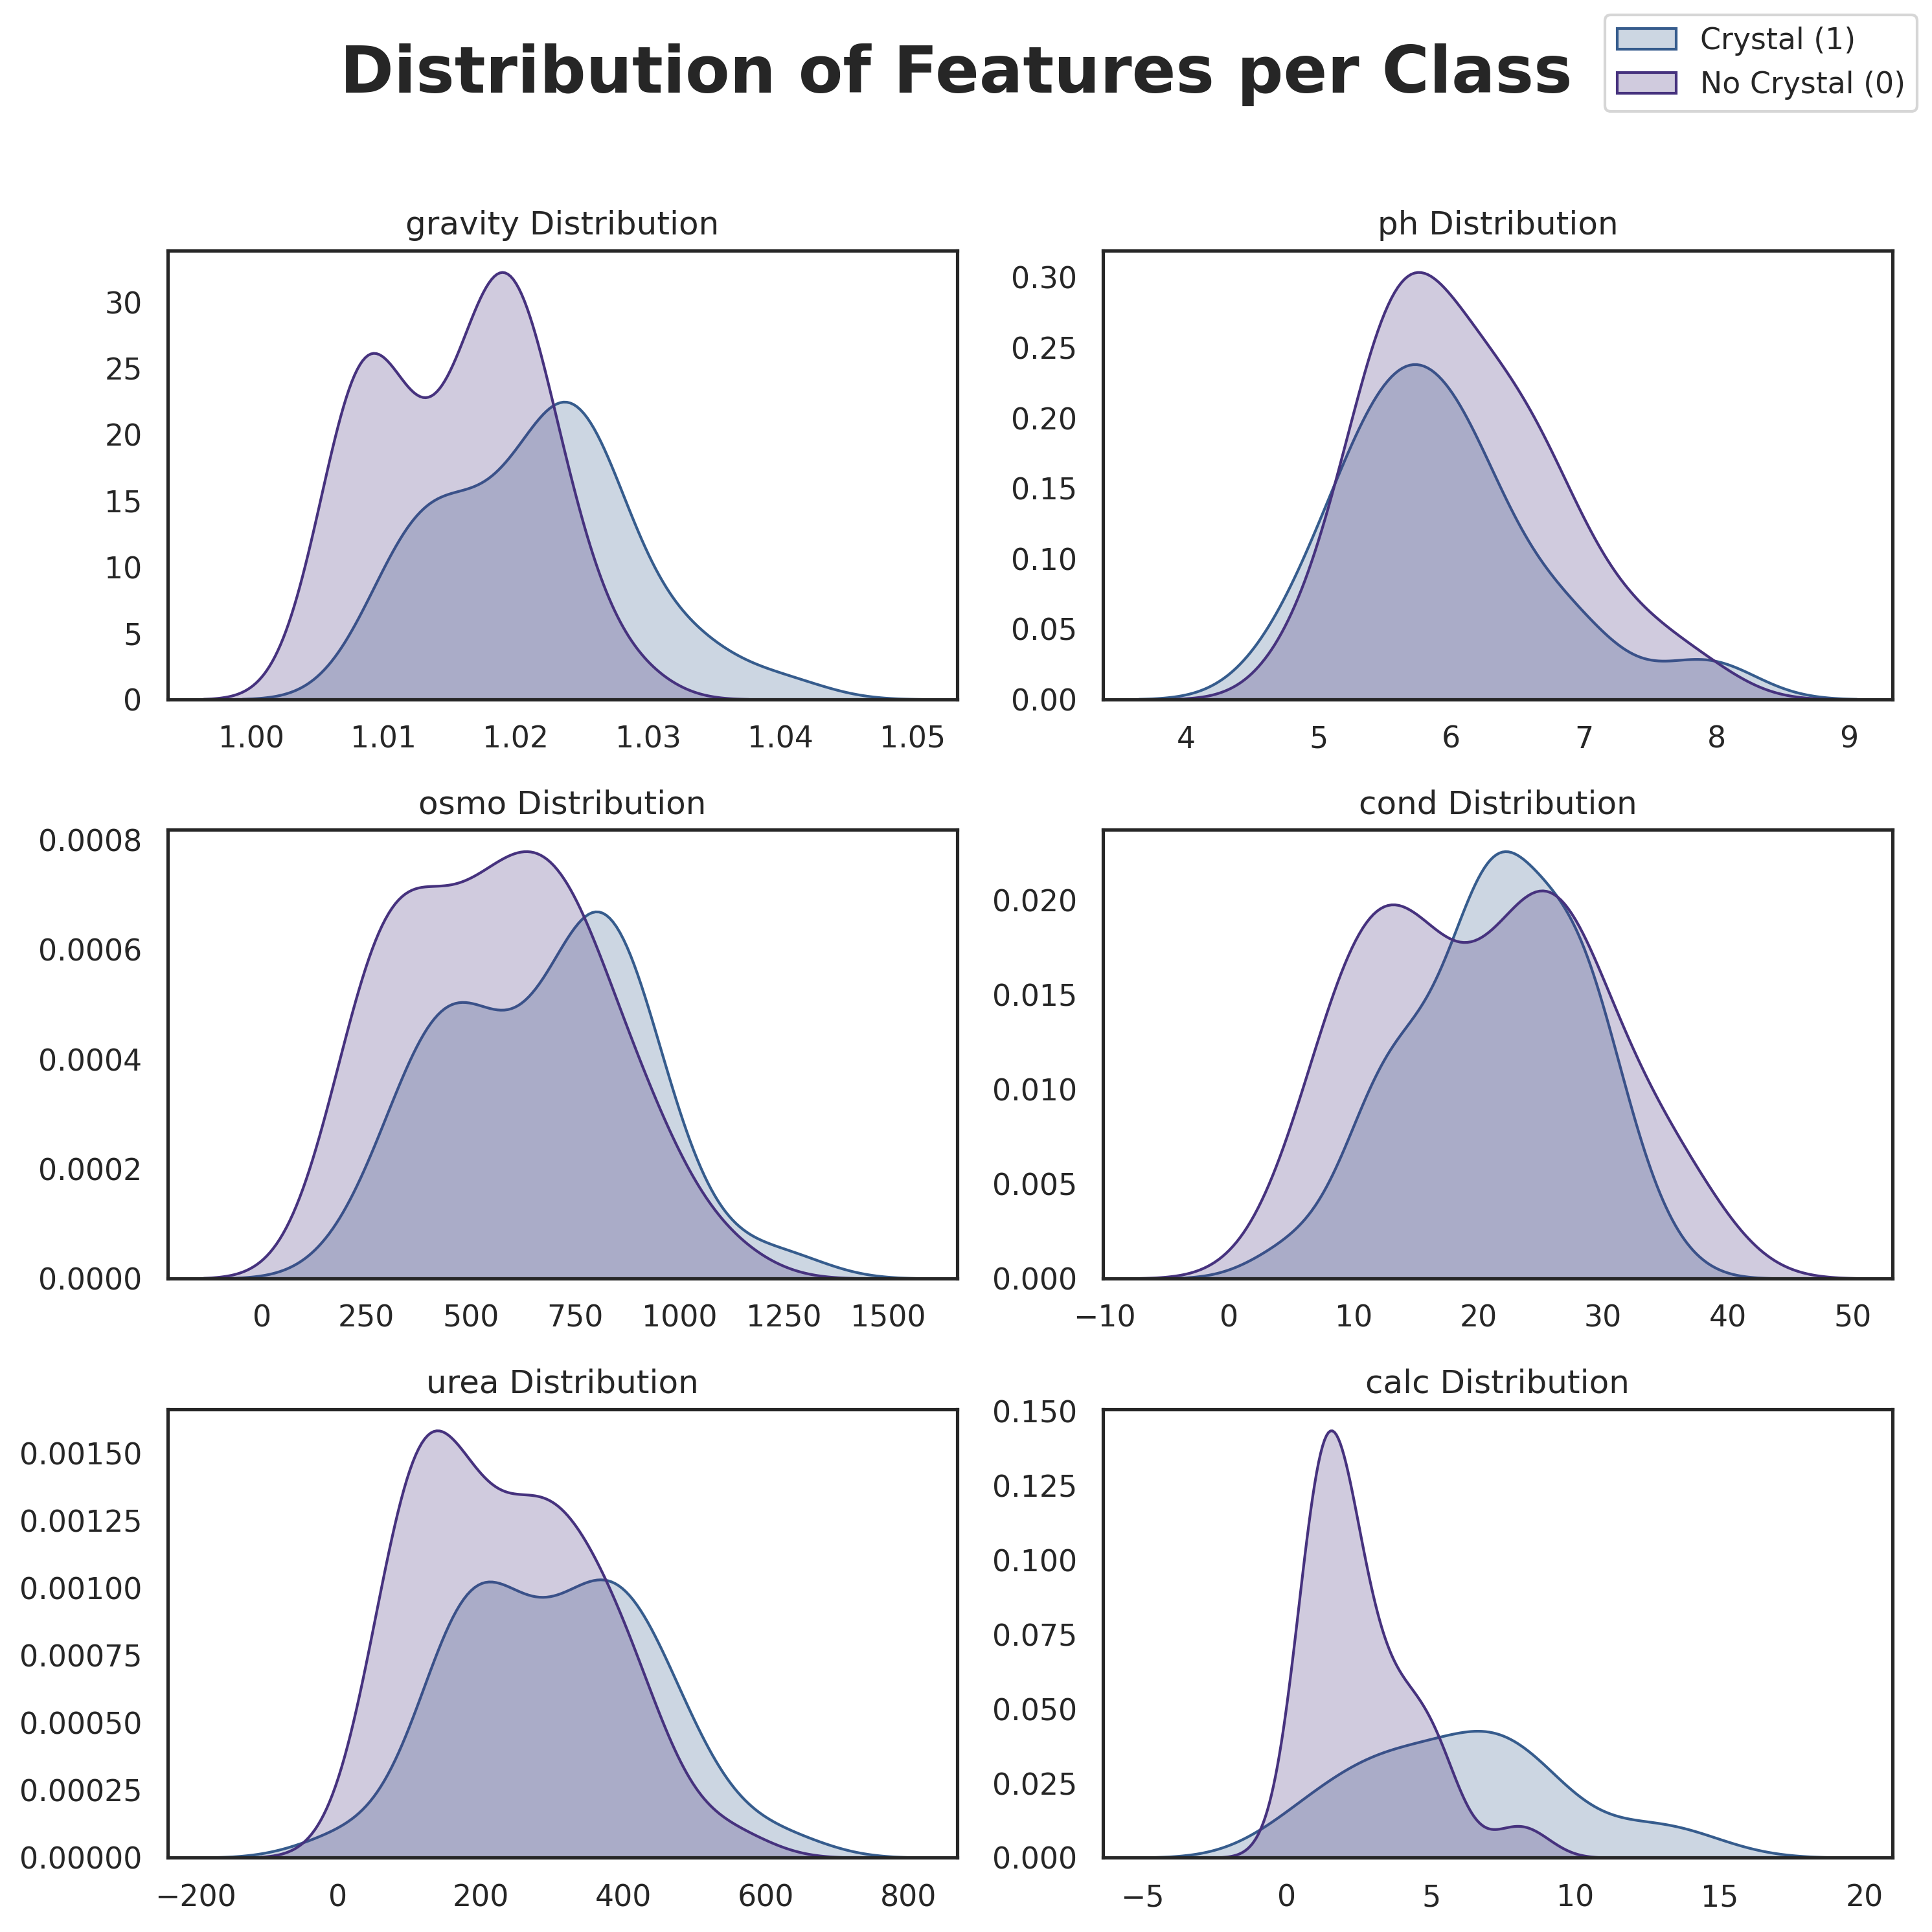

In [10]:
fig, ax = plt.subplots(3, 2, figsize = (10, 10), dpi = 300)
ax = ax.flatten()

for i, column in enumerate(test.columns):
    sns.kdeplot(data = orig_train, x = column, ax=ax[i], color=pal[0], fill = True, legend = False, hue = 'target')
    
    ax[i].set_title(f'{column} Distribution')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(None)
    
fig.suptitle('Distribution of Features per Class\n', fontsize = 24, fontweight = 'bold')
fig.legend(['Crystal (1)', 'No Crystal (0)'])
plt.tight_layout()

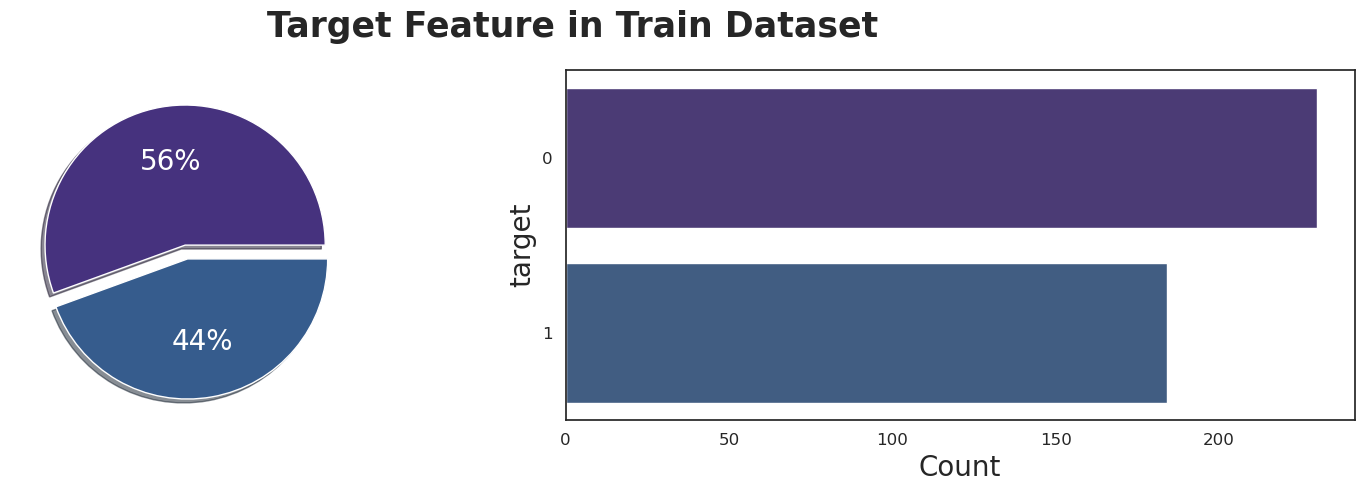

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax = ax.flatten()

ax[0].pie(
    train['target'].value_counts(), 
    shadow = True, 
    explode = [0, 0.1], 
    autopct = '%1.f%%',
    textprops = {'size' : 20, 'color' : 'white'}
)

sns.countplot(data = train, y = 'target', ax = ax[1])
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count', fontsize = 20)
plt.xticks(fontsize = 12)

fig.suptitle('Target Feature in Train Dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

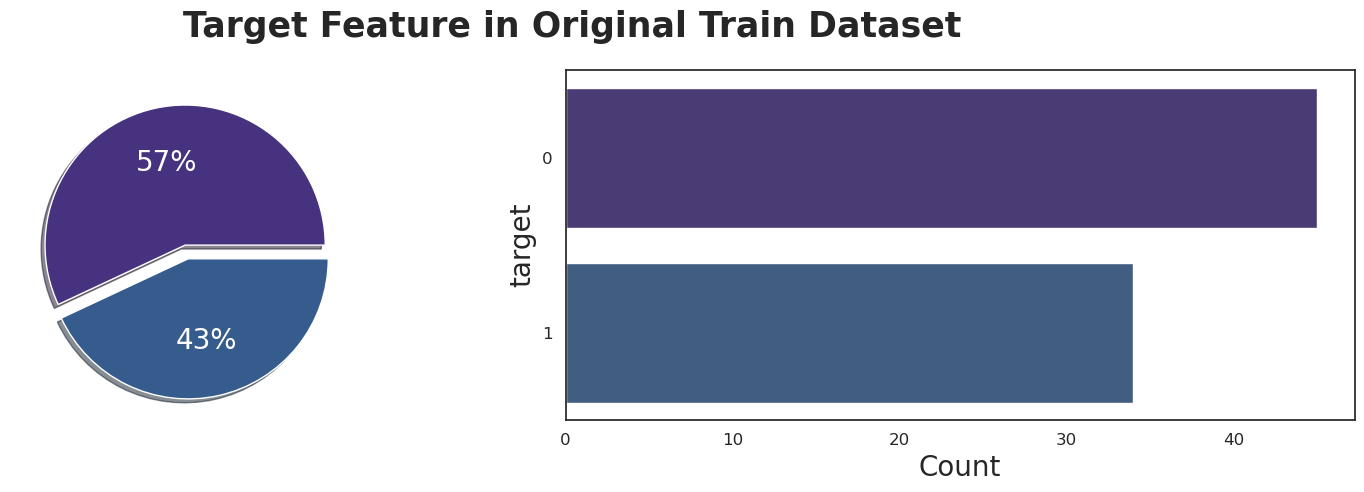

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax = ax.flatten()

ax[0].pie(
    orig_train['target'].value_counts(), 
    shadow = True, 
    explode = [0, 0.1], 
    autopct = '%1.f%%',
    textprops = {'size' : 20, 'color' : 'white'}
)

sns.countplot(data = orig_train, y = 'target', ax = ax[1])
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count', fontsize = 20)
plt.xticks(fontsize = 12)

fig.suptitle('Target Feature in Original Train Dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

In [13]:
def heatmap(dataset, label = None):
    corr = dataset.corr()
    plt.figure(figsize = (14, 10), dpi = 300)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask = mask, annot = True, annot_kws = {'size' : 14}, cmap = 'viridis')
    plt.yticks(fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.title(f'{label} Dataset Correlation Matrix\n', fontsize = 25, weight = 'bold')
    plt.show()

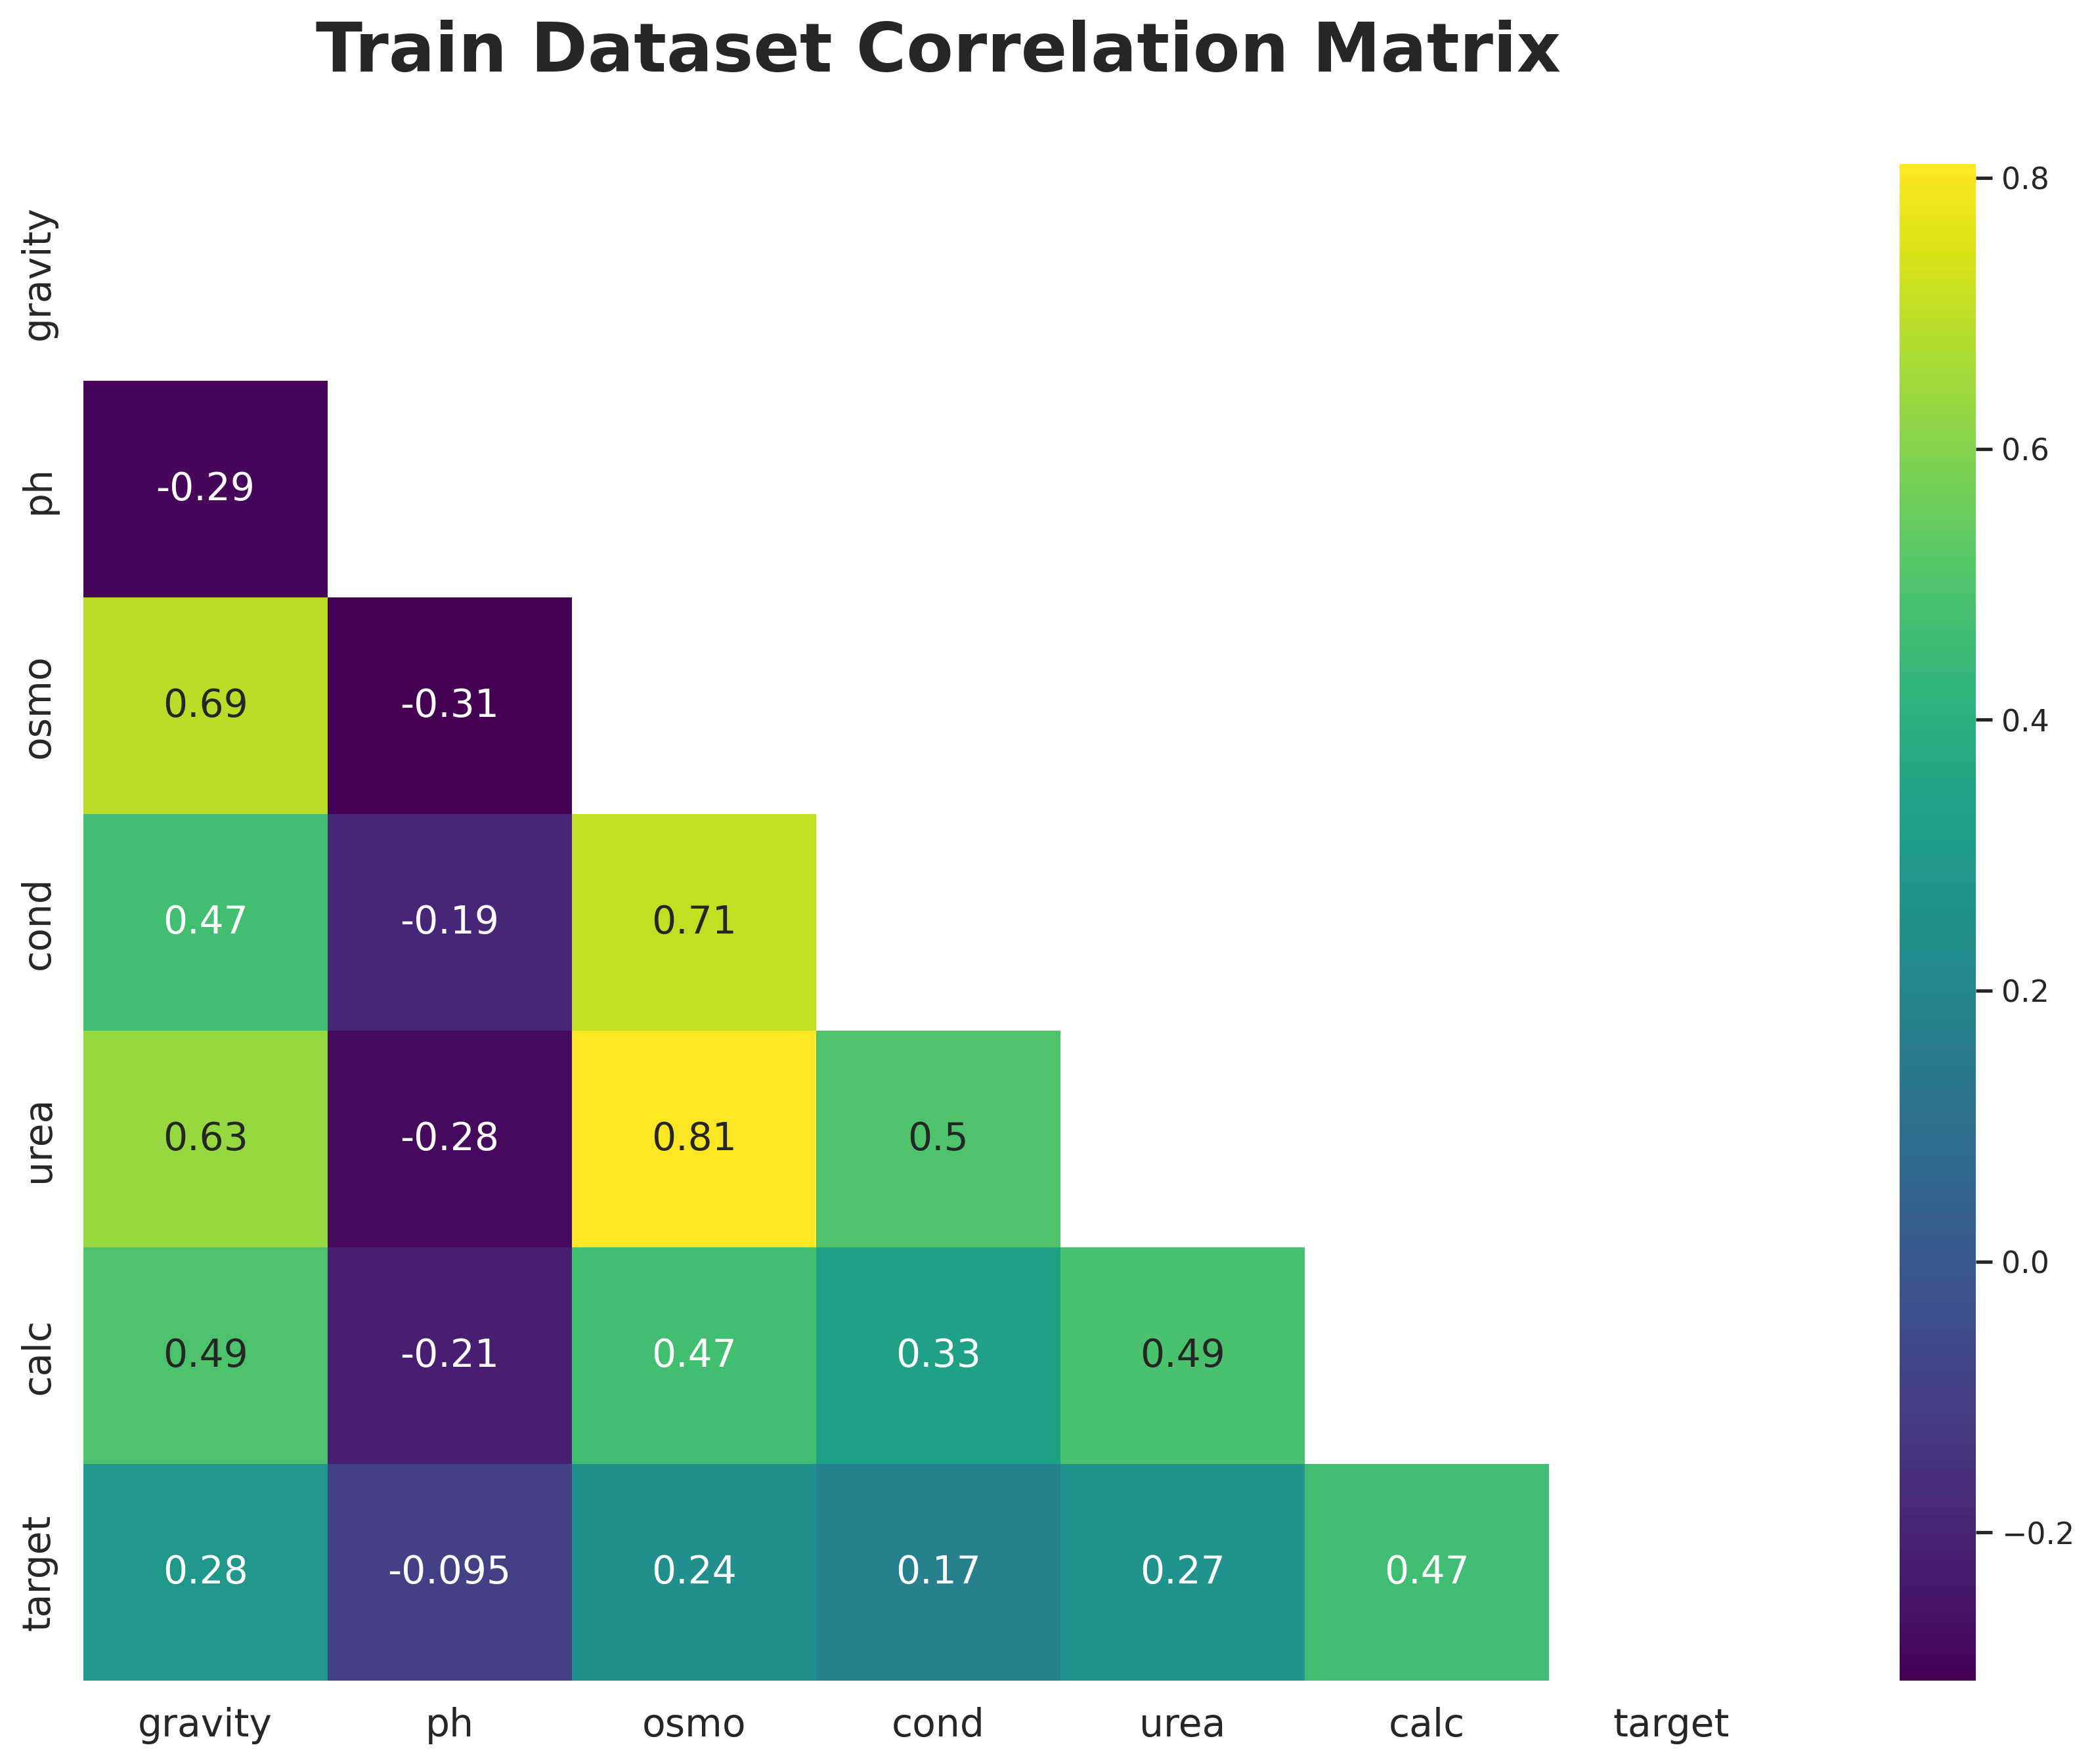

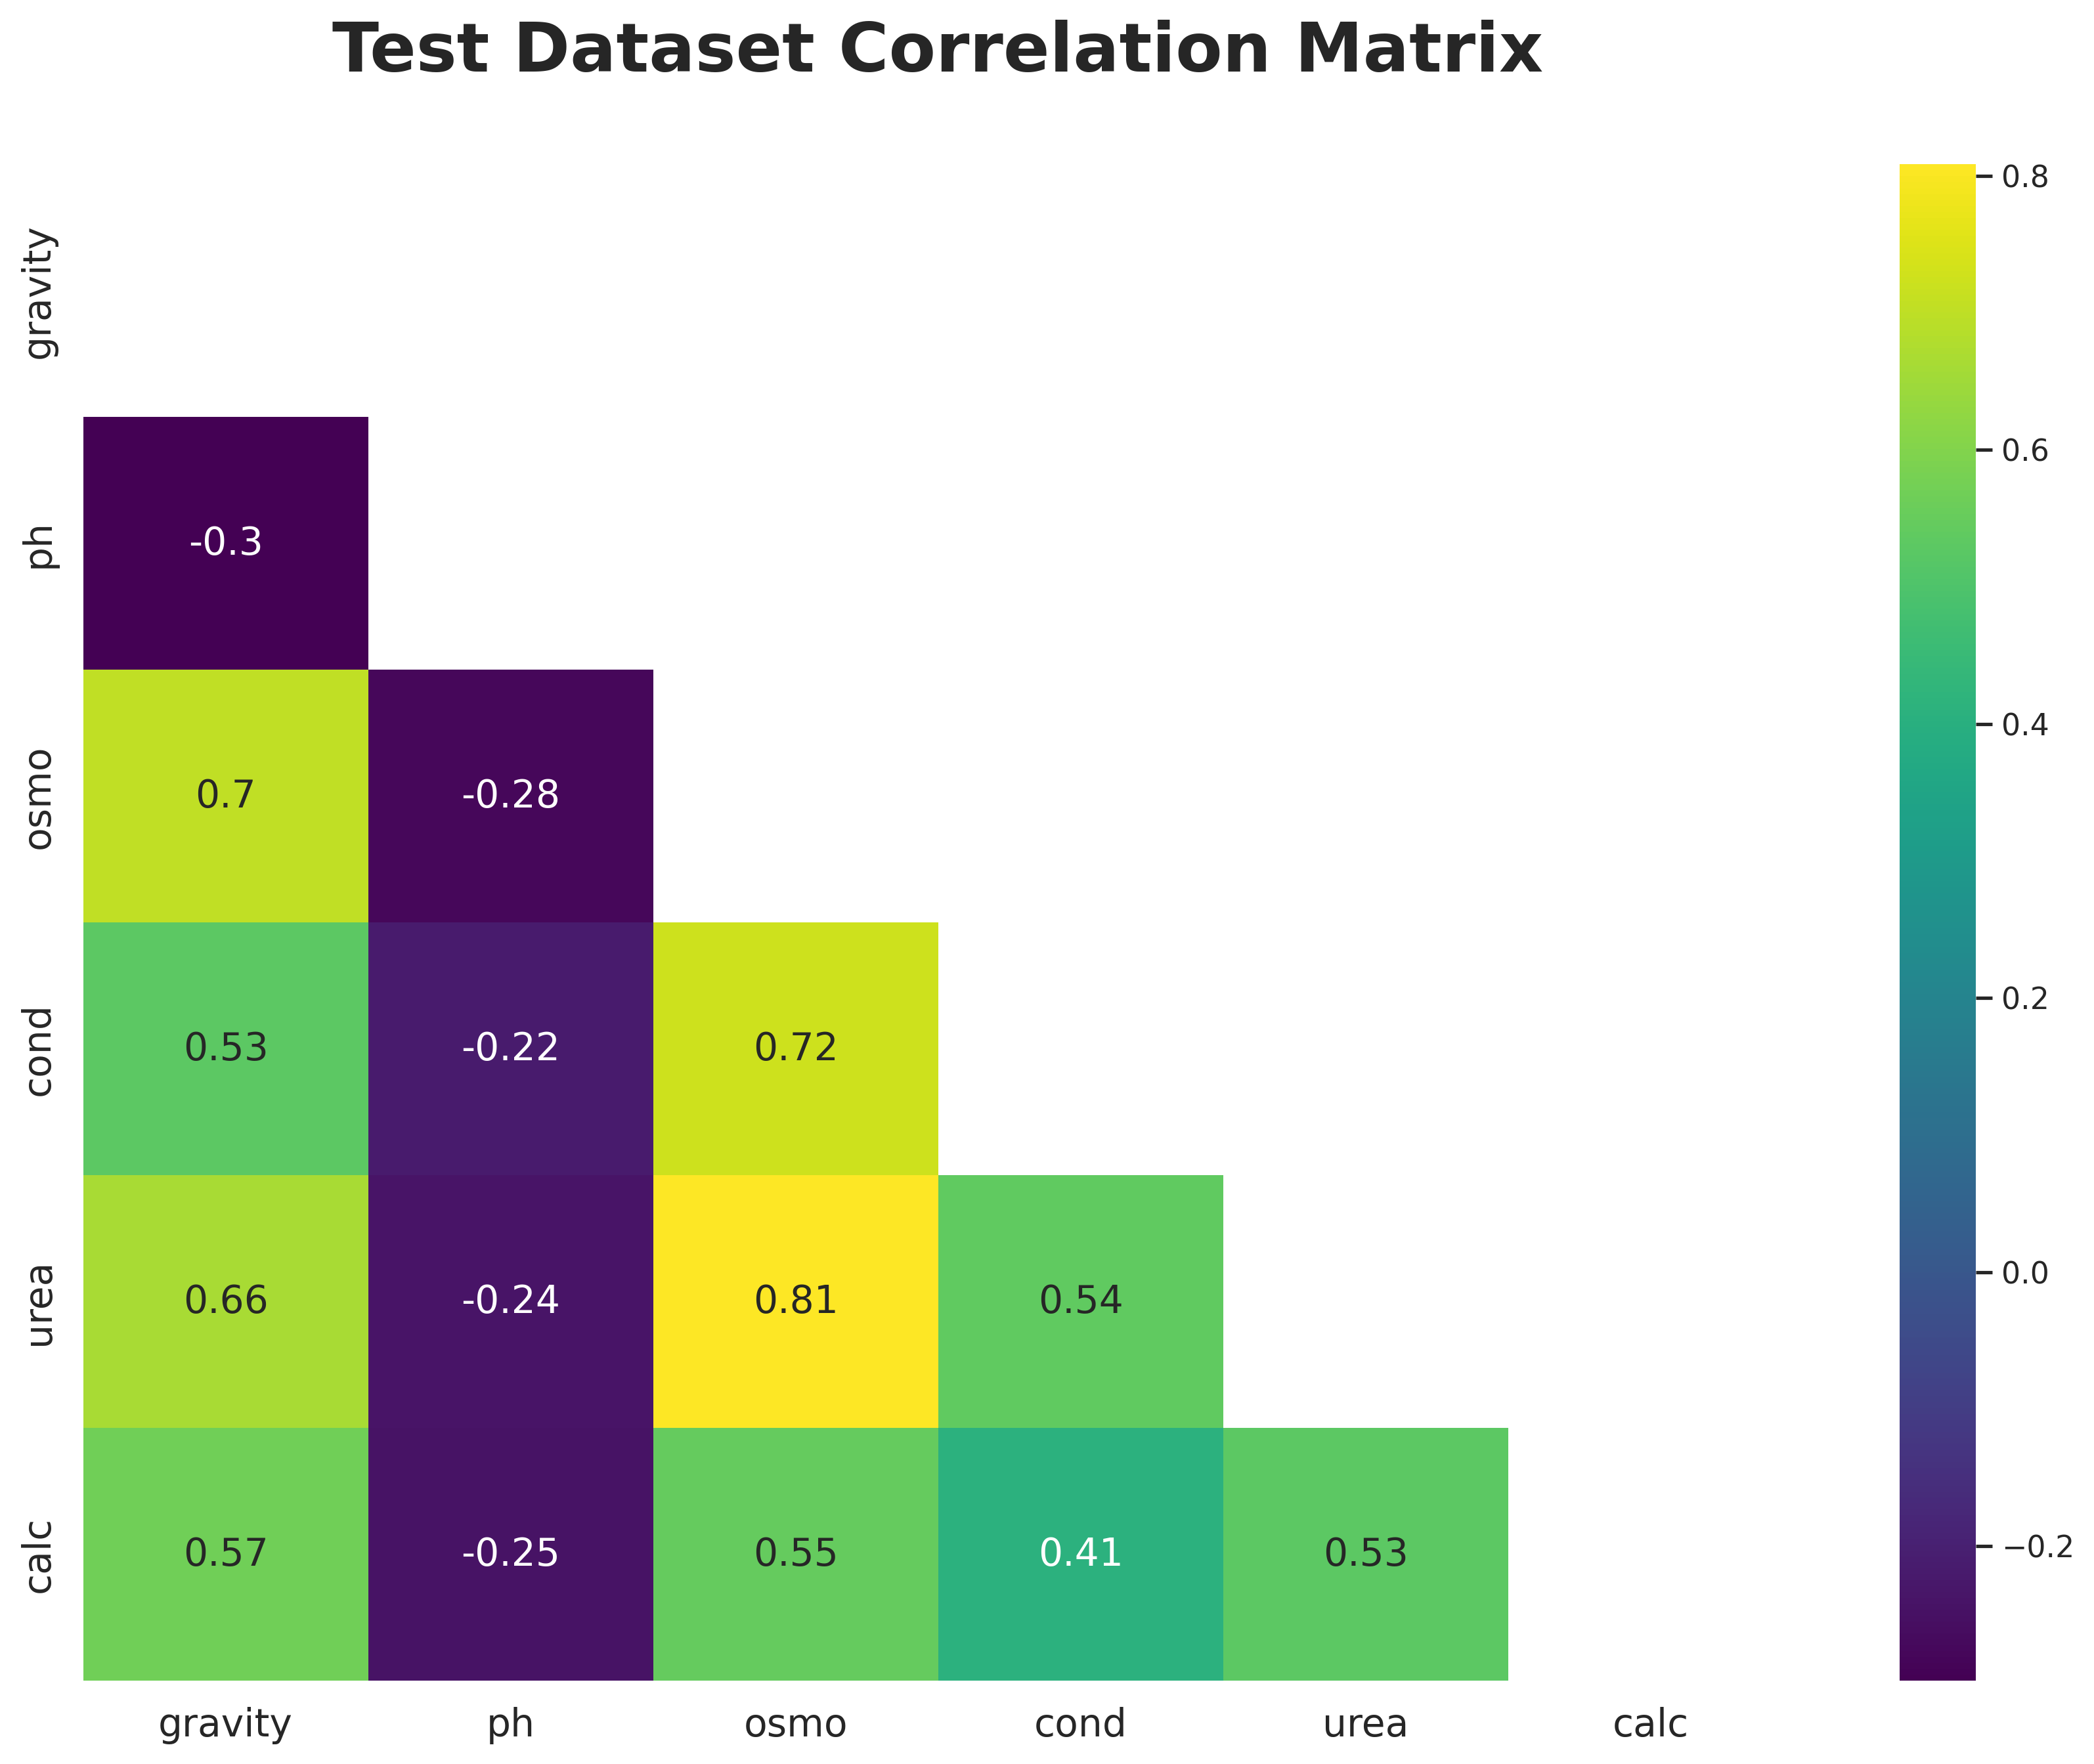

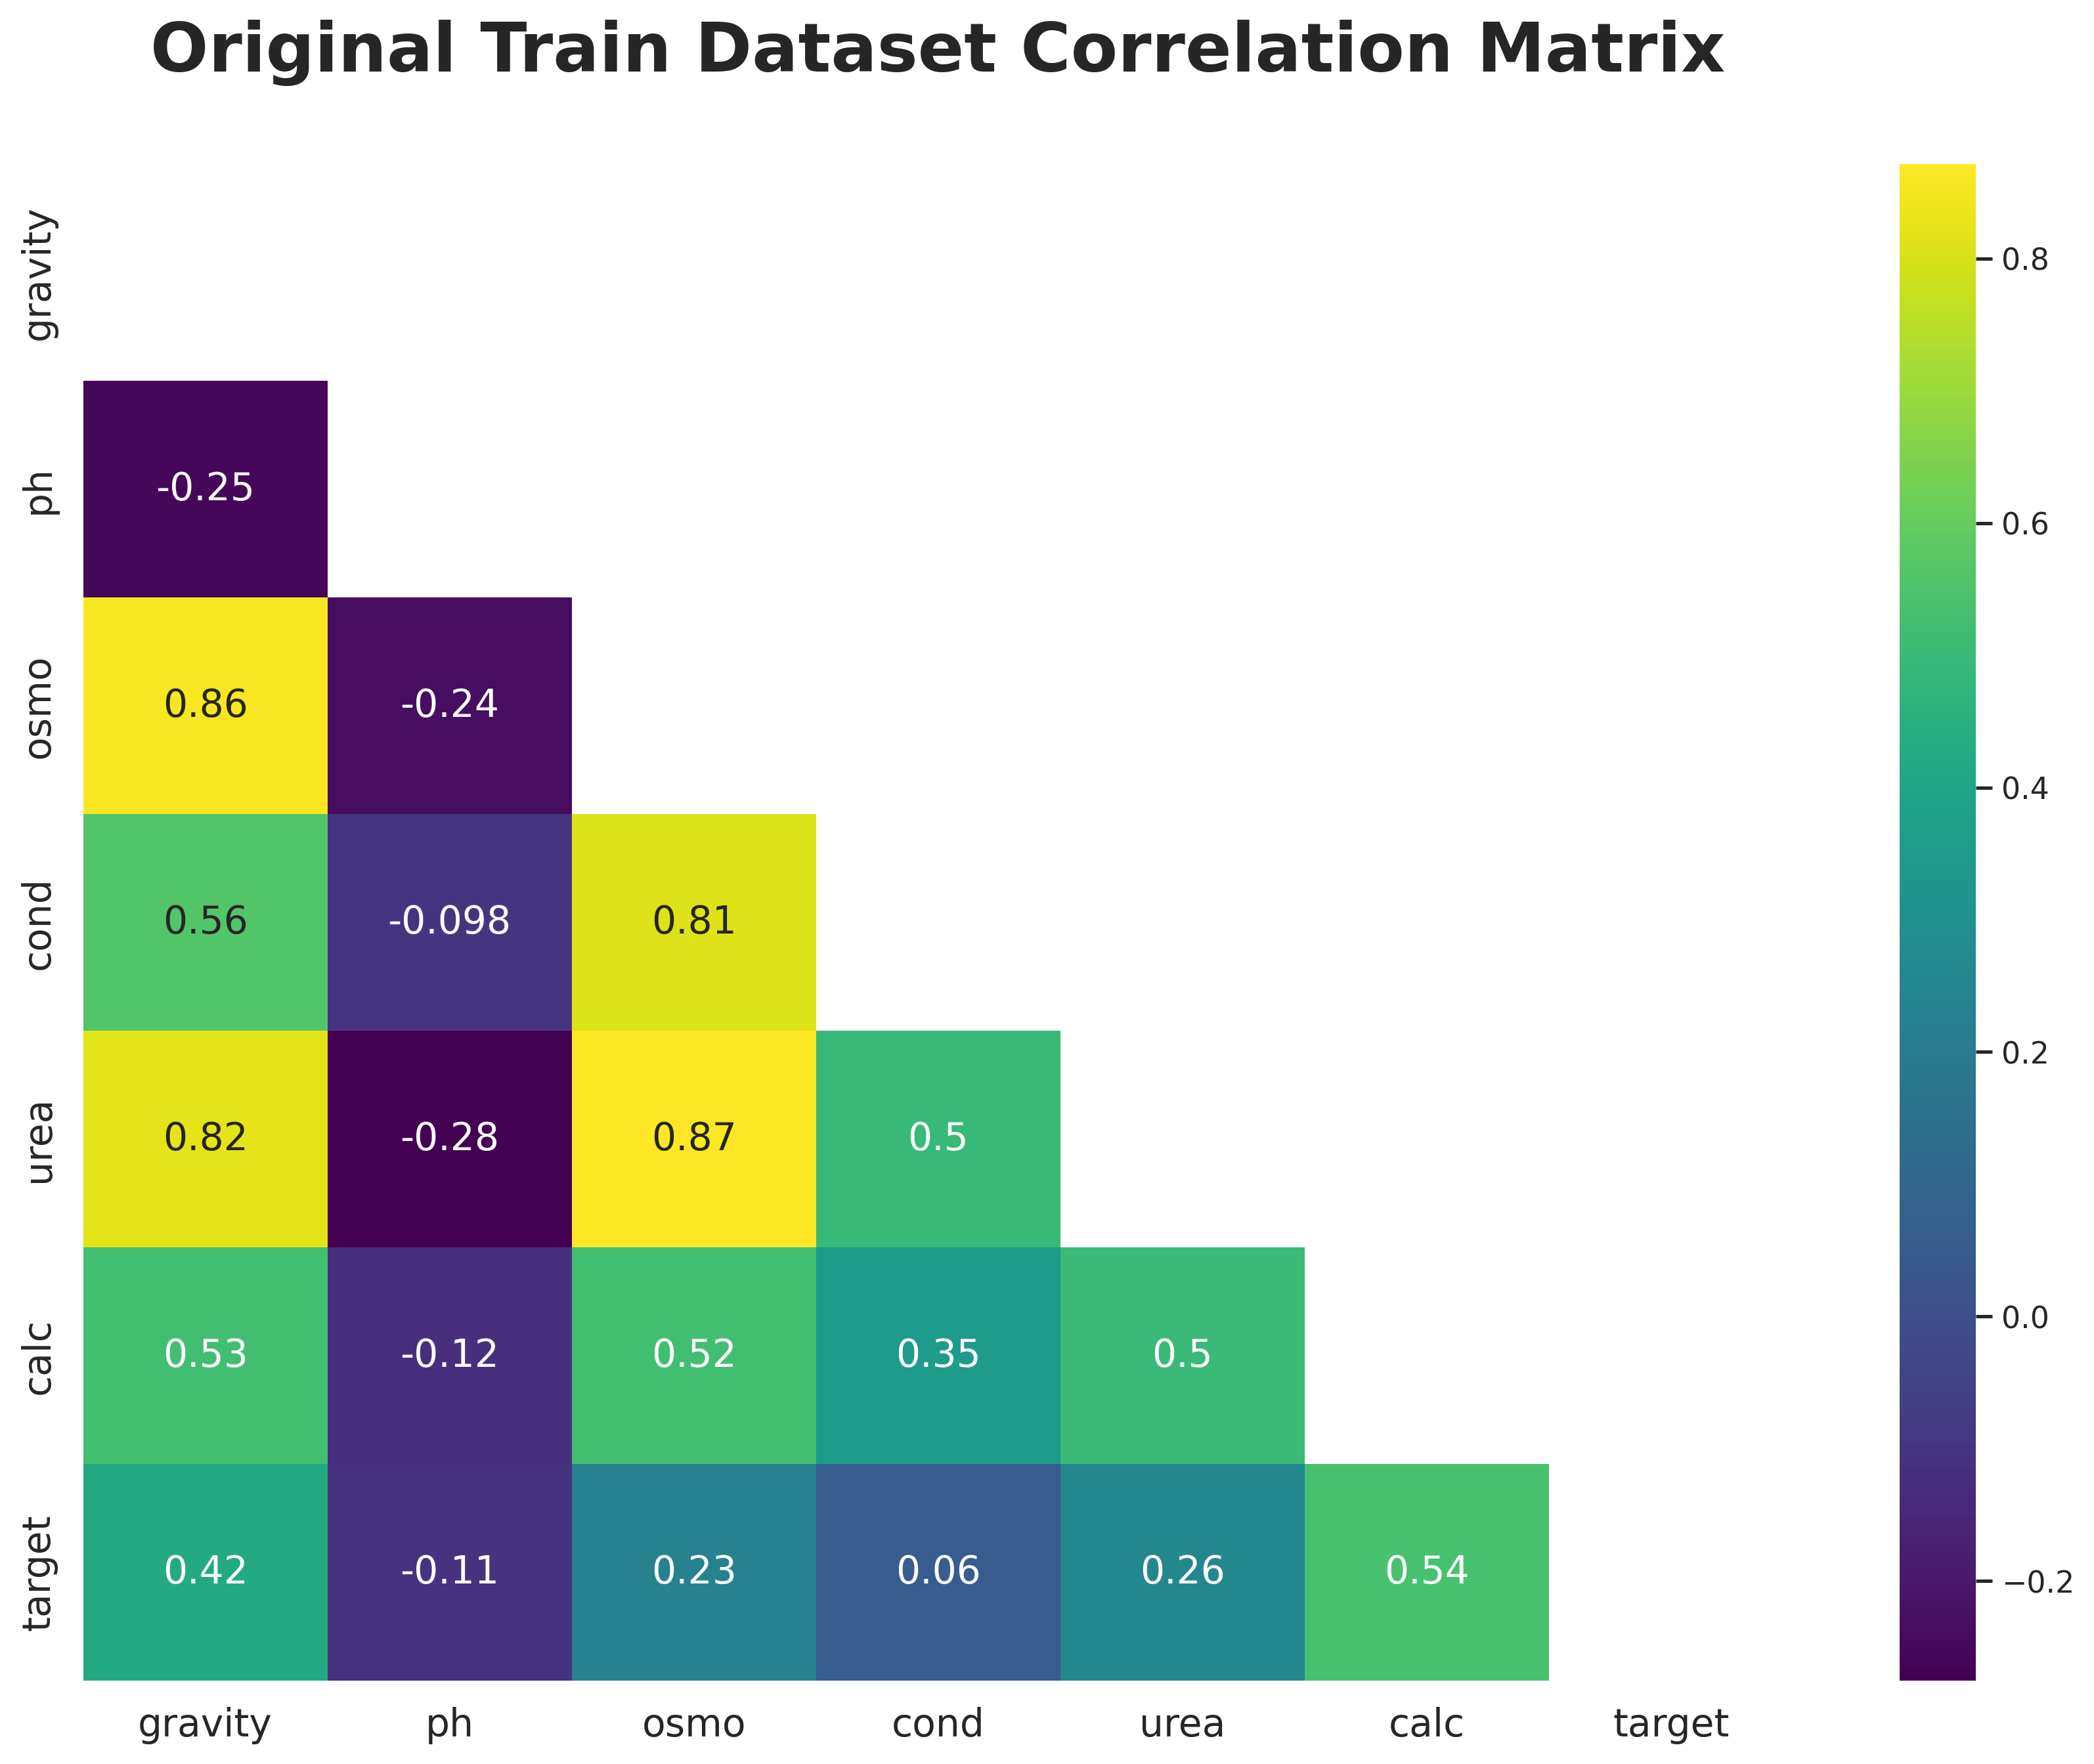

In [14]:
heatmap(train, "Train")
heatmap(test, "Test")
heatmap(orig_train, "Original Train")

In [15]:
sm.Logit(train['target'], sm.add_constant(train.drop('target', axis = 1))).fit().summary()

Optimization terminated successfully.
         Current function value: 0.563132
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                  414
Model:                          Logit   Df Residuals:                      407
Method:                           MLE   Df Model:                            6
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:                  0.1803
Time:                        04:51:58   Log-Likelihood:                -233.14
converged:                       True   LL-Null:                       -284.40
Covariance Type:            nonrobust   LLR p-value:                 7.434e-20
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.6859     24.675     -1.203      0.229     -78.047      18.675
gravity       27.1215     24.384      1.112      0.266     -20.671      74.914
ph             0.0921      0.187      0.491      0.623      -0.275       0.459
osmo          -0.0005      0.001     -0.456      0.648      -0.003       0.002
cond           0.0002      0.022      0.010      0.992      -0.043       0.044
urea           0.0008      0.001      0.556      0.578      -0.002       0.004
calc           0.3468      0.050      6.956      0.000       0.249       0.444
==============================================================================
"""

In [16]:
train = pd.concat([train, orig_train])

print(f"There are {train.duplicated(subset = list(train)[0:-1]).value_counts()[0]} no-duplicate values out of {train.count()[0]} row in train dataset")

There are 491 no-duplicate values out of 493 row in train dataset


In [18]:
train.drop_duplicates(subset = list(train)[0:-1], inplace = True, keep = 'first')

In [19]:
X = train.copy()
y = X.pop('target')

seed = 42
splits = 10
repeats = 10
k = RepeatedStratifiedKFold(n_splits=splits, random_state=seed, n_repeats = repeats)

np.random.seed(seed)

In [20]:
X = X[["calc"]]
test = test[["calc"]]

In [21]:
xgb_params = {
    'seed': seed,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method' : 'exact',
    'n_jobs' : -1,
    
    'max_depth' : 2,
    'eta' : .01,
    'n_estimators' : 100
}

predictions = np.zeros(len(test))
train_scores, val_scores = [], []
k = RepeatedStratifiedKFold(n_splits=splits, random_state=seed, n_repeats = repeats)
for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):
    
    stack = StackingClassifier(
        [
            ('xgb', XGBClassifier(**xgb_params)),
            ('lr', LogisticRegression(penalty = 'l2', solver = 'saga', max_iter = 10000)),
            ('ext', ExtraTreesClassifier(random_state = seed, min_samples_leaf = 10))
        ]
    )
    
    stack.fit(X.iloc[train_idx], y.iloc[train_idx])
    
    train_preds = stack.predict_proba(X.iloc[train_idx])[:,1]
    val_preds = stack.predict_proba(X.iloc[val_idx])[:,1]
    
    train_score = roc_auc_score(y.iloc[train_idx], train_preds)
    val_score = roc_auc_score(y.iloc[val_idx], val_preds)
    
    train_scores.append(train_score)
    val_scores.append(val_score)
    
    predictions += stack.predict_proba(test)[:,1] / splits / repeats
    #print(f'Fold {fold // repeats} Iteration {fold % repeats}: val ROC = {val_score:.5f} | train ROC = {train_score:.5f}')

print(f'Average val ROC = {np.mean(val_scores):.5f} | train ROC = {np.mean(train_scores):.5f}')
stack_preds = predictions.copy()

Average val ROC = 0.81442 | train ROC = 0.82894


In [22]:
test_1.drop(list(test_1.drop('id', axis = 1)), axis = 1, inplace = True)

In [23]:
test_1["target"] = stack_preds
test_1.to_csv("submission.csv", index = False)